## mag_auto_calc

Testing MAG_AUTO calculations using [SEP](https://github.com/kbarbary/sep), which has the functionality of SExtractor wrapped in Python.

In [1]:
# math, array manipulation, etc.
import numpy as np

# timing
from timeit import default_timer

import astropy.io.fits as fits
from astropy.table import Table                    # Table data structure
import astropy.units as u

# necessary utilities from scipy, astropy and photutils
from scipy.optimize import differential_evolution
from scipy.ndimage import maximum_filter, gaussian_filter
from astropy.modeling import functional_models
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip
from photutils.background import Background2D, StdBackgroundRMS
from photutils.segmentation import deblend_sources, SegmentationImage, detect_sources

# plots
import matplotlib.pyplot as plt
import corner                       # giant triangle confusograms!

#%matplotlib inline

# MCMC sampling package
import emcee
from tqdm import tqdm

# SEP
import sep

import os

import sys
print(sys.version)


/Users/aidan/opt/anaconda3/envs/gal-gal-sel/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]


In [2]:
sys.path.append('/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/')

from lensphoto import LensPhoto, fwhm2sigma

from aidan_utils import plot_prettier, read_fits_image, get_fits_files

# only need to run once
plot_prettier()

In [3]:
jr_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/'
jg_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/'

files_r = get_fits_files(jr_path)
files_g = get_fits_files(jg_path)

index = 96

img_r = fits.open(files_r[index])[0].data
img_g = fits.open(files_g[index])[0].data

print(files_r[index])
print(files_g[index])

/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/DESJ233459.1960-640406.9600_r.fits
/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/DESJ233459.1960-640406.9600_g.fits


In [4]:
# begin by calling a quick fit

# then test bootstrapping using the example in the pyimfit documentation

# then run an MCMC call and compare posterior distributions using corner
# (change to imfit's likelihood calculation, see ## comments in infit_mcmc function)

fwhm_r = 0.95
fwhm_g = 1.11

std_psf_r = fwhm2sigma(fwhm_r)
std_psf_g = fwhm2sigma(fwhm_g)


In [5]:
photo = LensPhoto(img_r = img_r, img_g = img_g
                  , std_psf_r = std_psf_r, std_psf_g = std_psf_g
                  , desid = '1')


[[2.6010718 2.91288   2.6010718 ... 2.8530056 2.6010718 2.6010718]
 [2.6010718 3.1672952 2.6010718 ... 2.6010718 2.6010718 2.6010718]
 [2.6010718 2.7784188 2.6010718 ... 2.7672813 2.6010718 2.7225587]
 ...
 [2.6763031 3.048866  2.6010718 ... 2.6010718 2.6010718 2.6010718]
 [2.6444654 2.6010718 2.6010718 ... 2.6010718 2.6010718 2.6010718]
 [2.6385667 2.6010718 2.6010718 ... 2.6489158 2.6010718 2.6010718]]
[[1.7916338 1.816215  1.7916338 ... 1.7916338 1.7916338 1.7916338]
 [1.7916338 1.7916338 1.7916338 ... 2.1407485 1.7916338 1.7916338]
 [1.8176123 1.7916338 1.7916338 ... 1.8033943 2.1581006 1.7916338]
 ...
 [1.7916338 1.956612  1.7916338 ... 1.7916338 1.7916338 1.7916338]
 [2.0953872 1.7916338 1.8719454 ... 1.9874676 1.7916338 1.9632646]
 [1.7916338 1.7916338 1.7916338 ... 1.7916338 1.7916338 1.7933462]]


/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py:208: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py:208: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
photo.mag_arrays()

NoSamplingError: Posterior distribution must be sampled first.

In [7]:
run, dist = photo.mcmc_run(nwalkers=20, steps=500)
# this is a good number of steps and walkers for the production run MCMCs

samples = photo.dist.reshape(-1, 8)

100%|█████████████████████████████████████████| 500/500 [02:39<00:00,  3.14it/s]


----------------------------



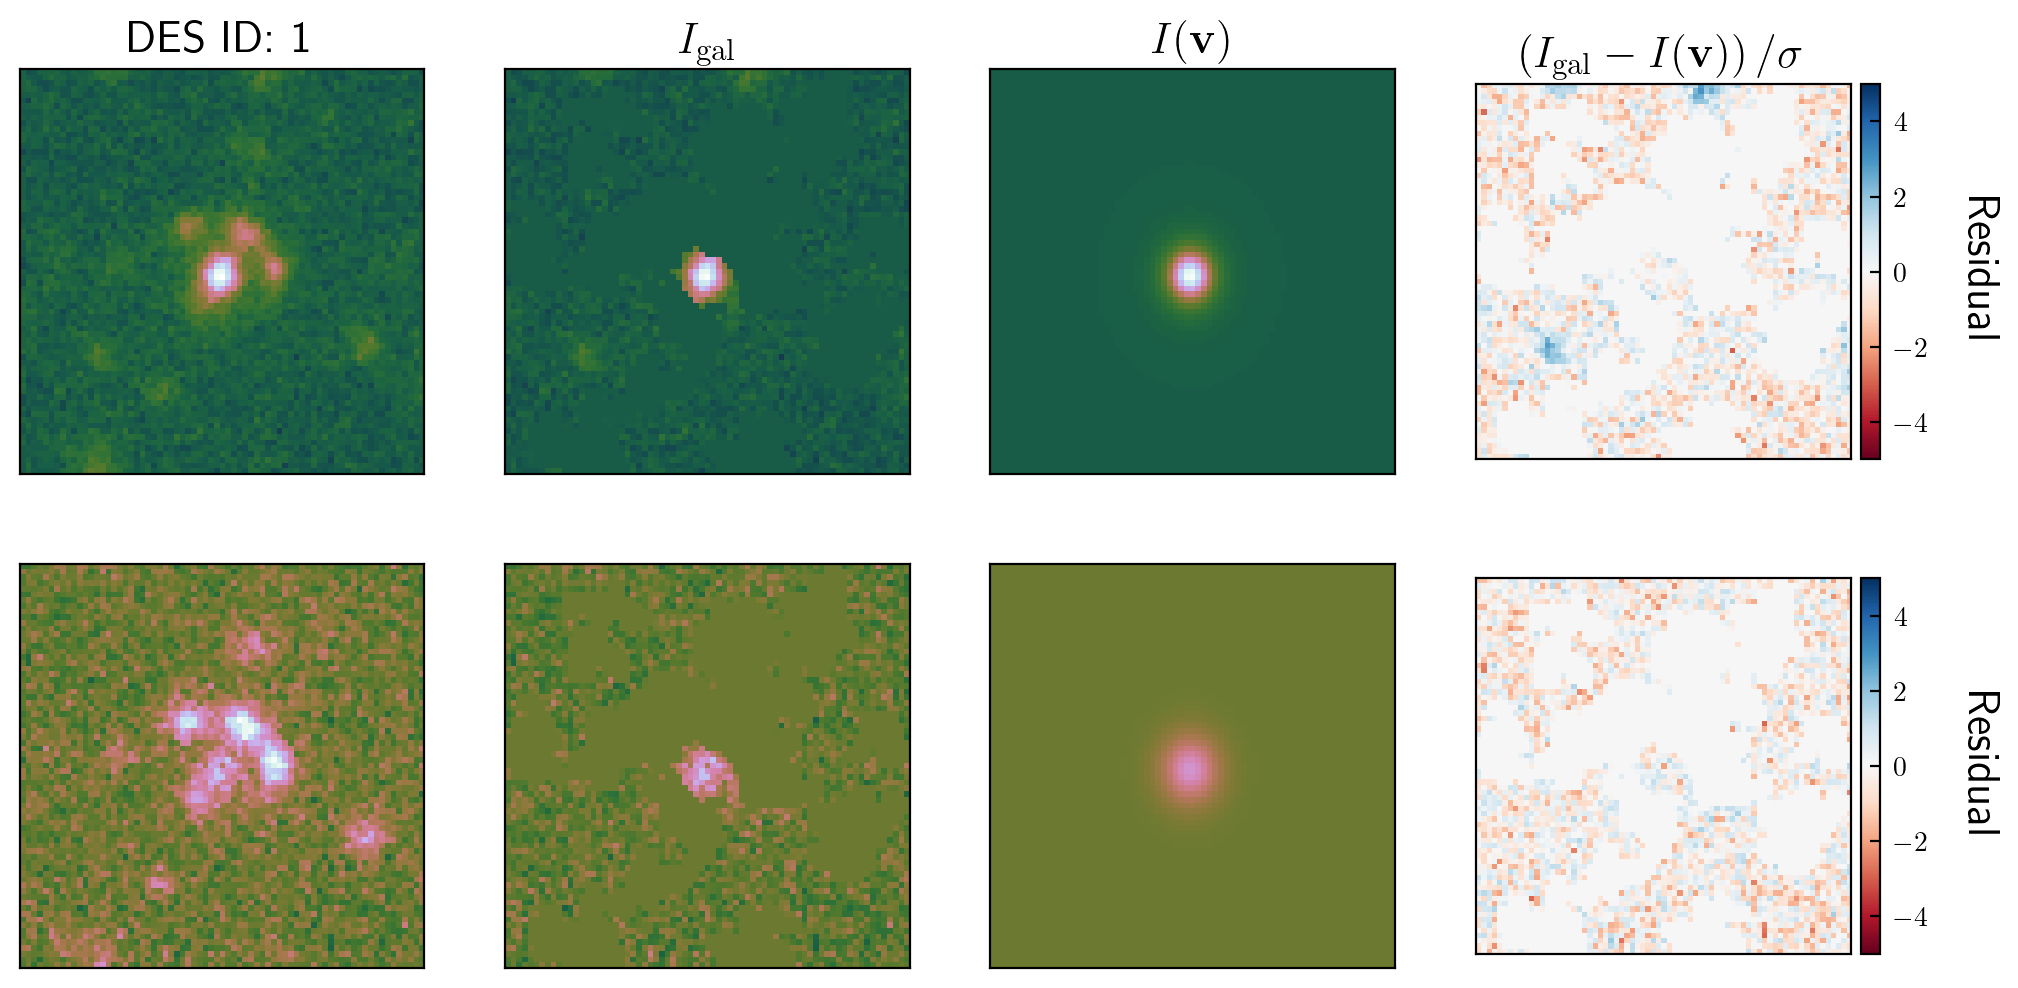

In [8]:
profile_r, profile_g = photo.plot_gal()


In [110]:
objs = sep.extract(photo.profile_r, 3, err=0.)

x, y, a, b, theta = objs['x'], objs['y'], objs['a'], objs['b'], objs['theta']
a,b

(array([4.14628935]), array([3.5341804]))

In [113]:
class NoSamplingError(Exception):
    pass

raise NoSamplingError('Posterior distribution must be sampled first.')

NoSamplingError: Posterior distribution must be sampled first.

In [106]:
kronrad, krflag = sep.kron_radius(photo.profile_r, x, y, a, b, theta, 6.0)

rscale = 15 * kronrad

flux, fluxerr, flag = sep.sum_ellipse(photo.profile_r, x, y, a, b, theta, rscale,
                                      subpix=1)

mag = -2.5*np.log10(flux) + 30
print(mag)

[21.09217828]


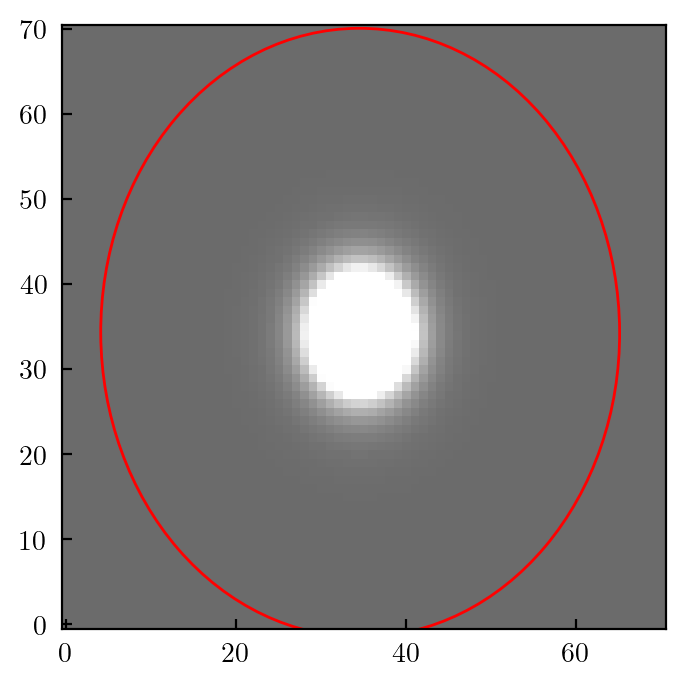

In [107]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(photo.profile_r), np.std(photo.profile_r)
im = ax.imshow(photo.profile_r, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objs['x'][i], objs['y'][i]),
                width=rscale*objs['a'][i],
                height=rscale*objs['b'][i],
                angle=objs['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)